In [2]:
import pandas as pd
import spacy
import string
from langdetect import detect
import re 
import nltk
from nltk.corpus import stopwords
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel

nlp = spacy.load("en_core_web_lg")

contractions_dict = { "ain’t": "are not", "’s":" is", "aren’t": "are not", "can’t": "cannot", 
                     "can’t’ve": "cannot have", "’cause": "because", "could’ve": "could have", 
                     "couldn’t": "could not", "couldn’t've": "could not have", "didn’t": "did not", 
                     "doesn’t": "does not", "don’t": "do not", "hadn’t": "had not", 
                     "hadn’t’ve": "had not have", "hasn’t": "has not", "haven’t": "have not",
                     "he’d": "he would", "he’d’ve": "he would have", "he’ll": "he will", 
                     "he’ll’ve": "he will have", "how’d": "how did", "how’d’y": "how do you", 
                     "how’ll": "how will", "i’d": "i would", "i’d’ve": "i would have", "i’ll": "i will",
                     "i’ll’ve": "i will have", "i’m": "i am", "i’ve": "i have", "isn’t": "is not",
                     "it’d": "it would", "it’d’ve": "it would have", "it’ll": "it will", 
                     "it’ll’ve": "it will have", "let’s": "let us", "ma’am": "madam", "mayn’t": "may not",
                     "might’ve": "might have", "mightn’t": "might not", "mightn’t’ve": "might not have",
                     "must’ve": "must have", "mustn’t": "must not", "mustn’t’ve": "must not have",
                     "needn’t": "need not", "needn’t’ve": "need not have", "o’clock": "of the clock",
                     "oughtn’t": "ought not", "oughtn’t’ve": "ought not have", "shan’t": "shall not",
                     "sha’n’t": "shall not", "shan’t’ve": "shall not have", "she’d": "she would",
                     "she’d’ve": "she would have", "she’ll": "she will", "she’ll’ve": "she will have", 
                     "should’ve": "should have", "shouldn’t": "should not", "shouldn’t’ve": "should not have",
                     "so’ve": "so have", "that’d": "that would", "that’d’ve": "that would have",
                     "there’d": "there would", "there’d’ve": "there would have", "they’d": "they would",
                     "they’d’ve": "they would have","they’ll": "they will", "they’ll’ve": "they will have",
                     "they’re": "they are", "they’ve": "they have", "to’ve": "to have", "wasn’t": "was not",
                     "we’d": "we would", "we’d’ve": "we would have", "we’ll": "we will", "we’ll’ve": "we will have",
                     "we’re": "we are", "we’ve": "we have", "weren’t": "were not","what’ll": "what will",
                     "what’ll've": "what will have", "what’re": "what are", "what’ve": "what have",
                     "when’ve": "when have", "where’d": "where did", "where’ve": "where have", 
                     "who’ll": "who will", "who’ll’ve": "who will have", "who’ve": "who have",
                     "why’ve": "why have", "will’ve": "will have", "won’t": "will not",
                     "won’t’ve": "will not have", "would’ve": "would have", "wouldn’t": "would not",
                     "wouldn’t’ve": "would not have", "y’all": "you all", "y’all’d": "you all would",
                     "y’all’d'’ve": "you all would have", "y’all’re": "you all are",
                     "y’all’ve": "you all have", "you’d": "you would", "you’d’ve": "you would have",
                     "you’ll": "you will", "you’ll’ve": "you will have", "you’re": "you are",
                     "you’ve": "you have"}


def expand_contractions(s, contractions_dict=contractions_dict):
  contractions_re = re.compile('(%s)'%'|'.join(contractions_dict.keys()))
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, s)


def clean_hashtag_url(post):
    """
    remove all hastags and website links from a string
    """    

    return " ".join(word for word in post.split(' ') if ("#" not in word and "http" not in word))

def punct_space(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """

    return token.is_punct or token.is_space

def rm_pattern(post):
    """
    function returning a string without "...see more" and website links from the post. 
    This function uses "re.sub" to remove a specific pattern"""

    post = re.sub("…see more",'', post) # replace pattern by an empty string
    post = re.sub('http','',post)
    return post

def preprocess(post):
    
    clean_text = post.translate(str.maketrans("", "", string.punctuation))
    clean_text = clean_text.replace("\n", " ")
    clean_text = clean_text.replace("\u200d", "")
    clean_text = clean_text.replace("\u200b", "")
    clean_text = clean_text.replace("▪", "")
    clean_text = clean_text.replace("’", "")
    clean_text = clean_text.replace("”", "")
    clean_text = clean_text.lower()
    stop_words = set(stopwords.words('english')) - {'we', 'i', 'you', 'our', 'himself', 'herself', 'him', 'hers', 'his', 'her', 'ourselves', 'themselves', 'ours'}
    clean_text = " ".join([word for word in clean_text.split() if word not in stop_words])
    clean_text = " ".join(clean_text.split())
    
    return clean_text

def rules(token):
    """
    conditions to select a specific token for the corpus cleaning
    used with all() function : return True if all True.
    Conditions are : no pure puncuation - no pure whitespace - not a stopword 
    - not a #word
    """

    return [not punct_space(token)] 

def corpus_cleaning(posts):
    """
    generator function using spaCy to parse posts,
    remove "...see more" pattern, website links, lemmatize the text, lowercase words, and apply all the conditions we have set in rules.
    What this function returns is a generator (a "list") of individual tokens contained in lists. 
    """
    
    for post in nlp.pipe(posts.apply(rm_pattern)):
        yield ' '.join([token.lemma_ for token in post if all(rules(token))])

def main_token(json_name,column_name_corpus):

    nltk.download('stopwords')
    df = pd.read_json(json_name)

    df['language'] = df[column_name_corpus].apply(detect)
    df=df[df['language']!= 'es'].drop('language', axis=1)

    corpus=df[column_name_corpus]

    corpus = corpus.apply(expand_contractions)

    corpus = corpus.apply(clean_hashtag_url)
    corpus = corpus.apply(preprocess)

    preprocessed_posts = corpus_cleaning(corpus)
    streamed_posts = (post.split(' ') for post in preprocessed_posts)
    all_posts = []
    for streamed_post in streamed_posts:
        post = ' '.join(streamed_post)
        all_posts.append(post)

    # Process after cleaning

    df['descripcion_clean'] = all_posts

    preprocessed_posts = corpus_cleaning(corpus)
    streamed_posts = (post.split(' ') for post in preprocessed_posts)
    bigram_model = Phrases(streamed_posts,min_count=5,threshold=10)

    bigram_posts = []

    preprocessed_posts = corpus_cleaning(corpus)
    streamed_posts = (post.split(' ') for post in preprocessed_posts)

    for streamed_post in streamed_posts:
        bigram_post = ' '.join(bigram_model[streamed_post])
        bigram_posts.append(bigram_post)

    clean_corpus=bigram_posts

    return clean_corpus
    

In [3]:
clean_corpus=main_token("accenture_linkedin.json","content")
print(clean_corpus)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wdmoreno\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['ready enter virtual world discover new frontier create strong bond brand business profit check our full report', 'ever_wonder technological advancement today life business tomorrow explore next frontier tech innovation', 'disruptionproof workflow fiction it reality industrial business tool need increase efficiency transparency already learn', 'truly new possibility lie ahead we arrive exciting frontier technology innovation explore four trend_shape future discover', '🗓 ️ save date key technology trend emerge our physical virtual world blend one share reality join_we special event we explore trend_shape business technology next_decade rsvp today', 'next wave business transformation merge our digital physical world create radically new opportunity business leader available we share 4 digital trend_shape future our new share reality 🔮', 'invest people reduce our impact planet we measure value across area our business explore drive change make', 'reinvention long onetime execution contin

## NLP Analysis

In [4]:
import nltk
nltk.download('punkt')

corpus_tok = [nltk.word_tokenize(sent) for sent in clean_corpus]
corpus_tok

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wdmoreno\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[['ready',
  'enter',
  'virtual',
  'world',
  'discover',
  'new',
  'frontier',
  'create',
  'strong',
  'bond',
  'brand',
  'business',
  'profit',
  'check',
  'our',
  'full',
  'report'],
 ['ever_wonder',
  'technological',
  'advancement',
  'today',
  'life',
  'business',
  'tomorrow',
  'explore',
  'next',
  'frontier',
  'tech',
  'innovation'],
 ['disruptionproof',
  'workflow',
  'fiction',
  'it',
  'reality',
  'industrial',
  'business',
  'tool',
  'need',
  'increase',
  'efficiency',
  'transparency',
  'already',
  'learn'],
 ['truly',
  'new',
  'possibility',
  'lie',
  'ahead',
  'we',
  'arrive',
  'exciting',
  'frontier',
  'technology',
  'innovation',
  'explore',
  'four',
  'trend_shape',
  'future',
  'discover'],
 ['🗓',
  '️',
  'save',
  'date',
  'key',
  'technology',
  'trend',
  'emerge',
  'our',
  'physical',
  'virtual',
  'world',
  'blend',
  'one',
  'share',
  'reality',
  'join_we',
  'special',
  'event',
  'we',
  'explore',
  'trend_s

In [5]:
from gensim.models import Word2Vec

# Define los parámetros de tu modelo personalizado
vector_size = 100
window_size = 5

# Construye el vocabulario de tu modelo utilizando las palabras del corpus tokenizado
model = Word2Vec(corpus_tok, vector_size=vector_size, window=window_size, min_count=1)

# Entrena el modelo Word2Vec con el corpus tokenizado
model.train(corpus_tok, total_examples=len(corpus_tok), epochs=500)

name_model= "biasAccenture_word2vec.model"
# Guarda el modelo entrenado para su uso posterior
model.save(name_model)

In [13]:
similares = model.wv.most_similar('student',topn=100)
similares

[('computer', 0.7202199697494507),
 ('sanjeev', 0.67406165599823),
 ('vohra', 0.6601614952087402),
 ('college', 0.6387620568275452),
 ('10yearold', 0.5277218222618103),
 ('terrific', 0.5157818794250488),
 ('ocean', 0.5050644278526306),
 ('expert', 0.5018289685249329),
 ('match', 0.49951809644699097),
 ('ha', 0.4976075291633606),
 ('artist', 0.49655681848526),
 ('penelope', 0.4911828339099884),
 ('36000', 0.48497721552848816),
 ('martha', 0.46995601058006287),
 ('prett', 0.46897485852241516),
 ('perspective', 0.4622673988342285),
 ('colleague', 0.4581379294395447),
 ('science', 0.44895046949386597),
 ('drama', 0.44612768292427063),
 ('selfmilke', 0.4438369572162628),
 ('guan', 0.43930381536483765),
 ('cotton', 0.43736153841018677),
 ('goodbye', 0.43545493483543396),
 ('recognition', 0.4335533082485199),
 ('superpower', 0.4312385320663452),
 ('lan', 0.42924898862838745),
 ('🏾', 0.4228925406932831),
 ('ebun', 0.42033421993255615),
 ('handscrawle', 0.41828179359436035),
 ('ok', 0.416790604

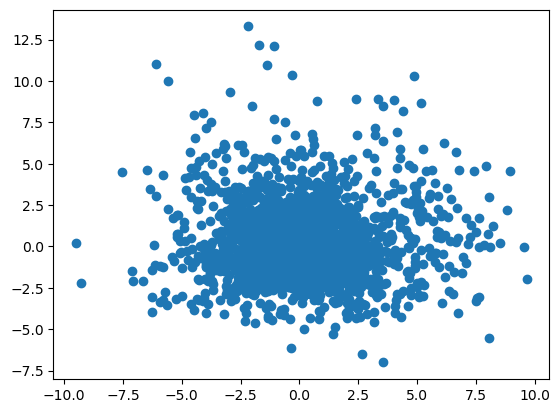

In [7]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# cargar modelo entrenado
model = Word2Vec.load(name_model)

# obtener vectores de palabras entrenados por Word2Vec
word_vectors = model.wv.vectors

# aplicar PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(word_vectors)

# graficar los componentes principales
plt.scatter(principal_components[:, 0], principal_components[:, 1])
plt.show()

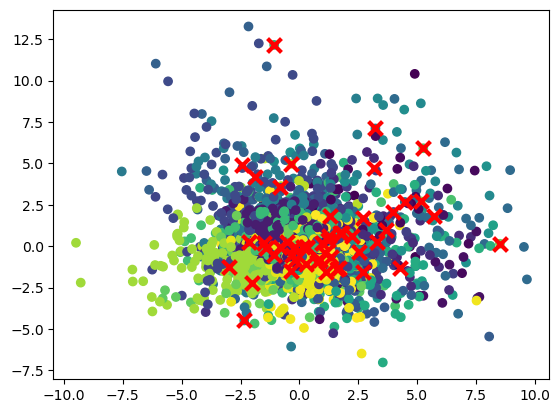

In [8]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# cargar modelo entrenado
model = Word2Vec.load(name_model)

# obtener vectores de palabras entrenados por Word2Vec
word_vectors = model.wv.vectors

# aplicar PCA
pca = PCA(n_components=100)
principal_components = pca.fit_transform(word_vectors)

# aplicar k-means
kmeans = KMeans(n_clusters=50, random_state=0)
kmeans.fit(principal_components)

# graficar los resultados de k-means
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', s=100, linewidths=3, color='r')
plt.show()

In [9]:
# obtener las etiquetas de los clusters para cada punto en el espacio 2D producido por PCA
labels = kmeans.predict(principal_components)

# crear un diccionario para almacenar las palabras por cluster
clusters = {}

# agregar cada palabra al cluster correspondiente
for i, word in enumerate(model.wv.index_to_key):
    cluster = labels[i]
    if cluster not in clusters:
        clusters[cluster] = []
    clusters[cluster].append(word)

# imprimir palabras por cluster
for cluster, words in clusters.items():
    print(f"Cluster {cluster}: {words}")



Cluster 21: ['our', 'people', 'work', 'story', 'career', 'her', 'thank', 'purpose', 'woman', 'program', 'incredible', 'everyone', 'around_world', 'three', 'real', 'moment', 'contribution', 'possible', 'importance', 'incredible_people', 'responsibility', 'amazing', 'everyday', 'great_place', 'mind', 'create_inclusive', 'family', 'place', 'z', 'uk', 'award', 'lgbt', 'positive_impact', 'member', 'volunteer', 'recognition', 'ellyn', 'sound', 'compassion', 'consultant', 'harshit', 'india', 'achievement', 'everywhere', 'socialize', 'thousand', 'remarkable', 'ana', '500k', 'gold', 'usa', 'harmony', 'count', '624000', 'collaborative', '721000']
Cluster 23: ['we', 'you', 'world', 'and', 'read', 'life', 'time', 'partner', 'action', 'together', 'solution', 'culture', 'big', 'part', 'practice', 'work_connect', 'back', 'successful', 'employer']
Cluster 25: ['business', 'company', 'see', 'organization', 'experience', 'accenture', 'drive', 'become', 'start', 'leadership', 'say', 'role', 'approach', '

In [10]:
import nltk
import re
import collections

limpio = []

for doc in clean_corpus:
    doc = doc.lower()
    palabras = re.findall(r'\b\w+\b', doc)
    limpio.extend(palabras)

frecuencia_palabras = collections.Counter(limpio).most_common()
num_palabras = len(limpio)
frecuencia_porcentaje = {palabra: (frecuencia/num_palabras)*100 for palabra, frecuencia in frecuencia_palabras}

for palabra, frecuencia in sorted(frecuencia_porcentaje.items(), key=lambda item: item[1], reverse=True):
    print(palabra, ": ", round(frecuencia, 2), "%")
    

our :  3.8 %
we :  2.22 %
business :  1.3 %
company :  1.12 %
people :  0.99 %
new :  0.92 %
you :  0.88 %
help :  0.83 %
see :  0.79 %
change :  0.73 %
value :  0.71 %
work :  0.65 %
make :  0.64 %
find :  0.62 %
technology :  0.61 %
learn :  0.55 %
create :  0.54 %
organization :  0.54 %
world :  0.46 %
need :  0.46 %
leader :  0.46 %
and :  0.45 %
future :  0.4 %
share :  0.39 %
one :  0.38 %
experience :  0.37 %
innovation :  0.37 %
well :  0.36 %
get :  0.34 %
accenture :  0.34 %
take :  0.34 %
read :  0.34 %
report :  0.32 %
drive :  0.32 %
way :  0.31 %
here :  0.29 %
impact :  0.29 %
industry :  0.29 %
live :  0.29 %
year :  0.28 %
community :  0.28 %
today :  0.27 %
growth :  0.27 %
customer :  0.27 %
digital :  0.26 %
life :  0.26 %
consumer :  0.25 %
global :  0.25 %
new_report :  0.25 %
explore :  0.24 %
time :  0.23 %
look :  0.23 %
team :  0.23 %
sustainable :  0.21 %
deliver :  0.21 %
focus :  0.21 %
cloud :  0.21 %
meet :  0.2 %
episode :  0.2 %
tech :  0.2 %
join_we : 